In [ ]:
# Standard library
from collections import Counter, defaultdict

# Drive
from google.colab import drive

# Data representation
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sb
import matplotlib.pyplot as plt
import graphviz

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedGroupKFold

# Modeling
from sklearn.tree import DecisionTreeClassifier, export_graphviz


In [ ]:
# Mounting to drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/CAERS_ProductBased.csv')
df

Mounted at /content/drive


,DATE_FDA_FIRST_RECEIVED_REPORT,REPORT_ID,DATE_EVENT,PRODUCT_TYPE,PRODUCT,PRODUCT_CODE,DESCRIPTION,PATIENT_AGE,AGE_UNITS,SEX,CASE_MEDDRA_PREFERRED_TERMS,CASE_OUTCOME,Unnamed: 12
0,6/30/2023,2023-CFS-006722,6/27/2023,SUSPECT,AIRLINE FOOD SERVED BY UNITED AIRLINES,37,Mult Food Dinner/Grav/Sauce/Special,45.0,year(s),Male,"Diarrhoea, Food poisoning, Pyrexia, Tremor, Vo...",Other Serious or Important Medical Event,NaN
1,6/30/2023,2023-CFS-006720,NaN,SUSPECT,ONE A DAY WOMEN'S,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,NaN,Suicidal ideation,Other Serious Outcome,NaN
2,6/30/2023,2023-CFS-006718,6/22/2023,SUSPECT,RITUAL ESSENTIAL PRENATAL MULTIVITAMIN,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,Female,Chest pain,"Hospitalization, Other Serious or Important Me...",NaN
3,6/30/2023,2023-CFS-006717,NaN,SUSPECT,METAMUCIL,54,Vit/Min/Prot/Unconv Diet(Human/Animal),46.0,year(s),Female,"Pain, Vomiting","Hospitalization, Other Serious or Important Me...",NaN
4,6/30/2023,2023-CFS-006714,NaN,SUSPECT,NATURE'S BOUNTY CALCIUM 1200MG PLUS 25MCG (100...,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,NaN,"Nephrolithiasis, Renal injury","Hospitalization, Visited Emergency Room, Other...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
206601,12/23/1999,100748,8/20/1999,SUSPECT,GERO VITA ARTHRO 7,54,Vit/Min/Prot/Unconv Diet(Human/Animal),65.0,year(s),Male,"BLINDNESS, DECREASED IMMUNE RESPONSIVENESS, HE...","Required Intervention, Visited a Health Care P...",NaN
206602,5/13/1999,100920,NaN,SUSPECT,AM 300,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,Female,"HEART RATE INCREASED, SYNCOPE",Hospitalization,NaN
206603,5/13/1999,100919,NaN,SUSPECT,AM-300,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,Female,"DIZZINESS, FEELING ABNORMAL","Hospitalization, Visited Emergency Room",NaN
206604,5/13/1999,100918,NaN,SUSPECT,AM 300,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,Female,"HYPERVENTILATION, PALPITATIONS","Hospitalization, Visited Emergency Room",NaN


# Data Preprocessing

In [ ]:
# REMOVING DATA ===============================================================
#Drop duplicate rows
df_nodupes = df.drop_duplicates()

#Drop product code column as it is repeated data from product descriptions
cols_to_drop = ["PRODUCT_CODE", "Unnamed: 12", "DATE_FDA_FIRST_RECEIVED_REPORT", "DATE_EVENT"]
df_nopc = df_nodupes.drop(columns = cols_to_drop).reset_index(drop=True)

#Lowercase all symptoms for uniformity
df_nopc['CASE_MEDDRA_PREFERRED_TERMS'] = df_nopc['CASE_MEDDRA_PREFERRED_TERMS'].str.lower()

#Remove abnormal row
df_nopc = df_nopc[df_nopc["PRODUCT"].isnull() == False]

# AGE =========================================================================
#Convert ages from all units to years only
def convert_age(row):
  age = row['PATIENT_AGE']
  units = row['AGE_UNITS']
  match units:
    case 'year(s)': return age
    case 'month(s)': return age / 12
    case 'week(s)': return age / 52
    case 'day(s)': return age / 365
    case 'decade(s)': return age * 10

#Replace columns
df_nopc['AGES_IN_YEARS'] = df_nopc.apply(convert_age, axis=1)
df_nopc = df_nopc.drop(['PATIENT_AGE', 'AGE_UNITS'], axis=1).reset_index(drop=True)

#Remove erroneously reported ages above 110 years
df_nopc = df_nopc[df_nopc['AGES_IN_YEARS'] <= 110]

# ENCODING ===================================================================
# Since the case outcomes might contain multiple outcomes per entry separated by commas,
# we first need to split these into lists of individual outcomes
case_outcome_lists = df_nopc['CASE_OUTCOME'].str.split(',').apply(lambda x: [outcome.strip() for outcome in x])

# Initialize for one-hot encoding
mlb_case_outcomes = MultiLabelBinarizer()

# Perform one-hot encoding
case_outcome_encoded = mlb_case_outcomes.fit_transform(case_outcome_lists)

# Creating a DataFrame from the encoded data
case_outcome_df = pd.DataFrame(case_outcome_encoded, columns=mlb_case_outcomes.classes_)

# Merging the one-hot encoded case outcomes back with the original data
df_nopc = df_nopc.reset_index(drop=True)
data_outcome_encoded = df_nopc.join(case_outcome_df).reset_index(drop=True)


In [ ]:
# Print preprocessed dataframe
data_outcome_encoded


,REPORT_ID,PRODUCT_TYPE,PRODUCT,DESCRIPTION,SEX,CASE_MEDDRA_PREFERRED_TERMS,CASE_OUTCOME,AGES_IN_YEARS,Allergic Reaction,Congenital Anomaly,...,Disability,Hospitalization,Injury,Life Threatening,Other Outcome,Other Serious Outcome,Other Serious or Important Medical Event,Required Intervention,Visited Emergency Room,Visited a Health Care Provider
0,2023-CFS-006722,SUSPECT,AIRLINE FOOD SERVED BY UNITED AIRLINES,Mult Food Dinner/Grav/Sauce/Special,Male,"diarrhoea, food poisoning, pyrexia, tremor, vo...",Other Serious or Important Medical Event,45.0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2023-CFS-006717,SUSPECT,METAMUCIL,Vit/Min/Prot/Unconv Diet(Human/Animal),Female,"pain, vomiting","Hospitalization, Other Serious or Important Me...",46.0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,2023-CFS-006712,SUSPECT,COKE ZERO,Soft Drink/Water,Male,"disorientation, fatigue, seizure","Life Threatening, Hospitalization, Other Serio...",65.0,0,0,...,0,1,0,1,0,0,1,0,0,0
3,2023-CFS-006687,SUSPECT,HUEL BLACK EDITION,Mult Food Dinner/Grav/Sauce/Special,Male,food poisoning,Other Serious or Important Medical Event,39.0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2023-CFS-006682,SUSPECT,GINKGO BILOBA,Vit/Min/Prot/Unconv Diet(Human/Animal),Female,"cardiac failure, death, hypoglycaemia, renal f...","Death, Hospitalization",92.0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122079,73153,SUSPECT,TRADER JOE'S CREAM OF SALMON SOUP,Soup,Female,"chest pain, dizziness, dyspnoea, hypoaesthesia...","Required Intervention, Visited Emergency Room",45.0,0,0,...,0,0,0,0,0,0,0,1,1,0
122080,67970,SUSPECT,CROWN PRINCE SARDINES IN TOMATO SAUCE,Fishery/Seafood Prod,Female,"abdominal pain upper, diarrhoea, vomiting","Visited Emergency Room, Visited a Health Care ...",72.0,0,0,...,0,0,0,0,0,0,0,0,1,1
122081,80767,SUSPECT,XENADRINE RFA-1,Vit/Min/Prot/Unconv Diet(Human/Animal),Female,"coronary artery dissection, coronary artery em...","Life Threatening, Hospitalization",50.0,0,0,...,0,1,0,1,0,0,0,0,0,0
122082,83971,SUSPECT,MINUTE MAID GRAPE JUICE,Fruit/Fruit Prod,NaN,"abdominal pain upper, diarrhoea, gastrointesti...",Other Outcome,1.0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Analysis

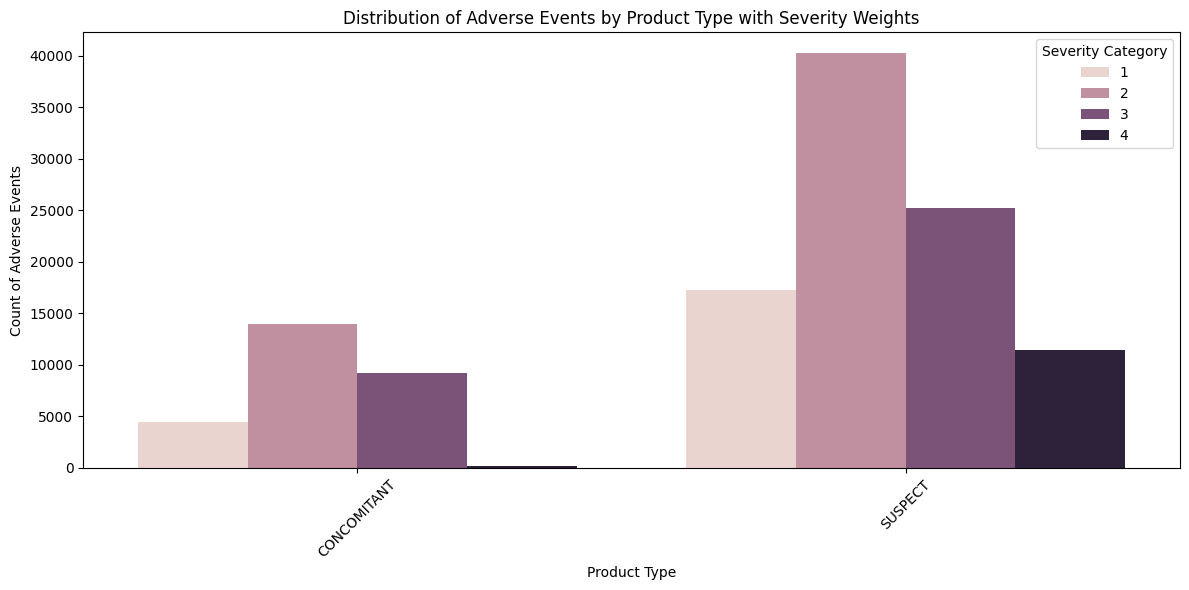

In [ ]:
# Assigning weights to each case_outcome
weights = {
    'Other Outcome': 1,
    'Visited a Health Care Provider': 1,
    'Allergic Reaction': 1,
    'Visited Emergency Room': 1,
    'Other Serious or Important Medical Event': 2,
    'Other Serious Outcome': 2,
    'Required Intervention': 2,
    'Injury': 3,
    'Hospitalization': 3,
    'Disability': 3,
    'Life Threatening': 3,
    'Congenital Anomaly': 3,
    'Death': 4,
}


# Ensure data types are correct for multiplication
for outcome in weights.keys():
    if outcome in data_outcome_encoded.columns:
        # Convert to numeric, treating non-numeric data as NaN, then replace NaN with 0
        data_outcome_encoded[outcome] = pd.to_numeric(data_outcome_encoded[outcome], errors='coerce').fillna(0)
        # Multiply by the weight
        data_outcome_encoded[outcome] = data_outcome_encoded[outcome] * weights[outcome]

# Get the maximum weight for each 'REPORT_ID'
data_outcome_encoded['CASE_OUTCOME_WEIGHTS'] = data_outcome_encoded[list(weights.keys())].max(axis=1)

# Now group by 'PRODUCT_TYPE' and 'CASE_OUTCOME_WEIGHTS' and count the occurrences
grouped_data = data_outcome_encoded.groupby(['PRODUCT_TYPE', 'CASE_OUTCOME_WEIGHTS']).size().reset_index(name='Count')

# Create the bar plot
plt.figure(figsize=(12, 6))
sb.barplot(
    data=grouped_data,
    x='PRODUCT_TYPE',
    y='Count',
    hue='CASE_OUTCOME_WEIGHTS'  # Using severity weight as hue
)

# Plotting
plt.title('Distribution of Adverse Events by Product Type with Severity Weights')
plt.xticks(rotation=45)
plt.ylabel('Count of Adverse Events')
plt.xlabel('Product Type')
plt.legend(title='Severity Category')
plt.tight_layout()
plt.show()


In [ ]:
# Split symptoms
def separate_symptoms(input):
    return [s.strip() for s in input.split(",")]

# Get set of all symptoms
all_symptoms = defaultdict(int)
def get_all_symptoms(input_list):
    for elem in input_list:
        all_symptoms[elem] += 1

# Count symptom frequency
def get_counts(word): return all_symptoms[word]

# Get incidence of all symptoms present in original dataframe
symptoms = df_nopc["CASE_MEDDRA_PREFERRED_TERMS"].apply(separate_symptoms)
symptoms.apply(get_all_symptoms)
df_symptoms = pd.DataFrame(data=list(all_symptoms.keys()), columns=["symptom"])
df_symptoms["incidence"] = df_symptoms["symptom"].apply(get_counts)

In [ ]:
# Print symptom occurrence
df_symptoms


,symptom,incidence
0,diarrhoea,13690
1,food poisoning,841
2,pyrexia,2557
3,tremor,1502
4,vomiting,12021
...,...,...
4694,gastrointestinal examination,1
4695,wound debridement,1
4696,mucosal discolouration,1
4697,sinus pain,2


<ipython-input-8-d17732a80587>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_cases['Severity_Category'] = pd.cut(unique_cases['CASE_OUTCOME_WEIGHTS'], bins=severity_bins, labels=severity_labels, include_lowest=True)


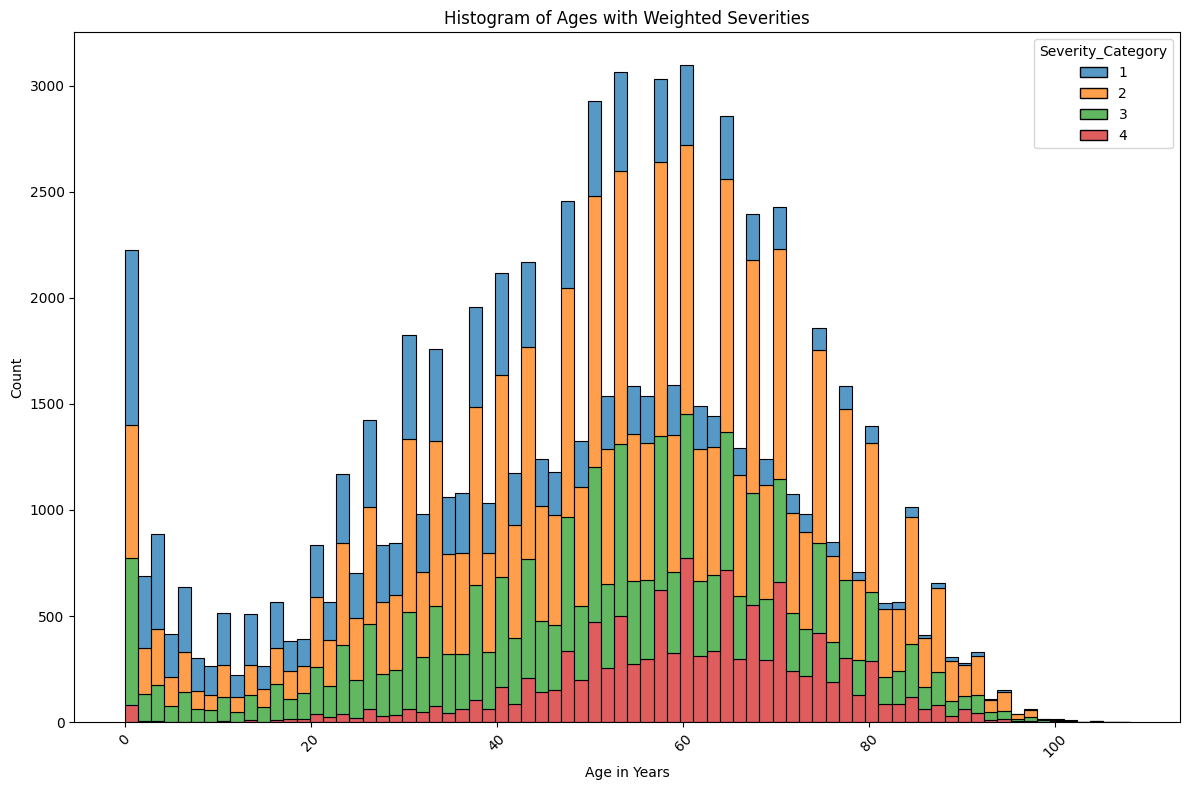

In [ ]:
# Remove duplicates: Keep the first occurrence of each unique CaseID
unique_cases = data_outcome_encoded.drop_duplicates(subset='REPORT_ID', keep='first')

severity_bins = [0, 1, 2, 3, 4]  # Define your bins edges
severity_labels = ['1', '2', '3', '4']  # Define your labels
unique_cases['Severity_Category'] = pd.cut(unique_cases['CASE_OUTCOME_WEIGHTS'], bins=severity_bins, labels=severity_labels, include_lowest=True)

# Create the histogram
plt.figure(figsize=(12, 8))
sb.histplot(
    data=unique_cases,
    x='AGES_IN_YEARS',
    hue='Severity_Category',  # This will color-code the histogram bars by severity category
    multiple='stack'  # Stacks the different severity categories on top of each other
)

plt.title('Histogram of Ages with Weighted Severities')
plt.xlabel('Age in Years')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels if there are many categories
plt.tight_layout()  # Adjust layout
plt.show()


# Modeling

In [ ]:
# Decision tree requires only numeric inputs, so convert categorical variables
# to numerical ones through label encoding, one-hot encoding
def preprocess_numeric(df):
    # Determine how to treat each column
    to_numeral = ["REPORT_ID", "PRODUCT"]
    to_ohe = ["PRODUCT_TYPE", "DESCRIPTION", "SEX"]
    to_drop = ["CASE_MEDDRA_PREFERRED_TERMS", "CASE_OUTCOME"] + list(weights.keys())

    # Drop unwanted columns
    df = df.drop(columns=to_drop)

    # One-hot encode
    df = pd.get_dummies(df, columns=to_ohe, prefix=to_ohe)

    # Convert categorical to numeric when OHE creates too many features
    le = LabelEncoder()
    for column in to_numeral:
        df[column] = le.fit_transform(df[column])

    return df

In [ ]:
# Get columns for X dataframe
X_cols = list(data_outcome_encoded.columns)
X_cols.remove("CASE_OUTCOME_WEIGHTS")

# Stratified K-fold split (with groups from REPORT_ID)
X, y = data_outcome_encoded[X_cols], data_outcome_encoded["CASE_OUTCOME_WEIGHTS"]
skfold = StratifiedGroupKFold(n_splits = 5)

# Run decision tree for each split
trees = []
for train_index, test_index in skfold.split(X, y):

    # Get training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Preprocess everything independently
    X_train, X_test = preprocess_numeric(X_train), preprocess_numeric(X_test)

    # Define and fit decision tree classifier
    clf = DecisionTreeClassifier(max_depth = 3)
    clf.fit(X_train, y_train)

    # Visualization of the tree
    dt_data = export_graphviz(
        clf, feature_names = X_train.columns.values, out_file = None,
        filled = True, rounded = True, special_characters = True)
    trees.append(graphviz.Source(dt_data))


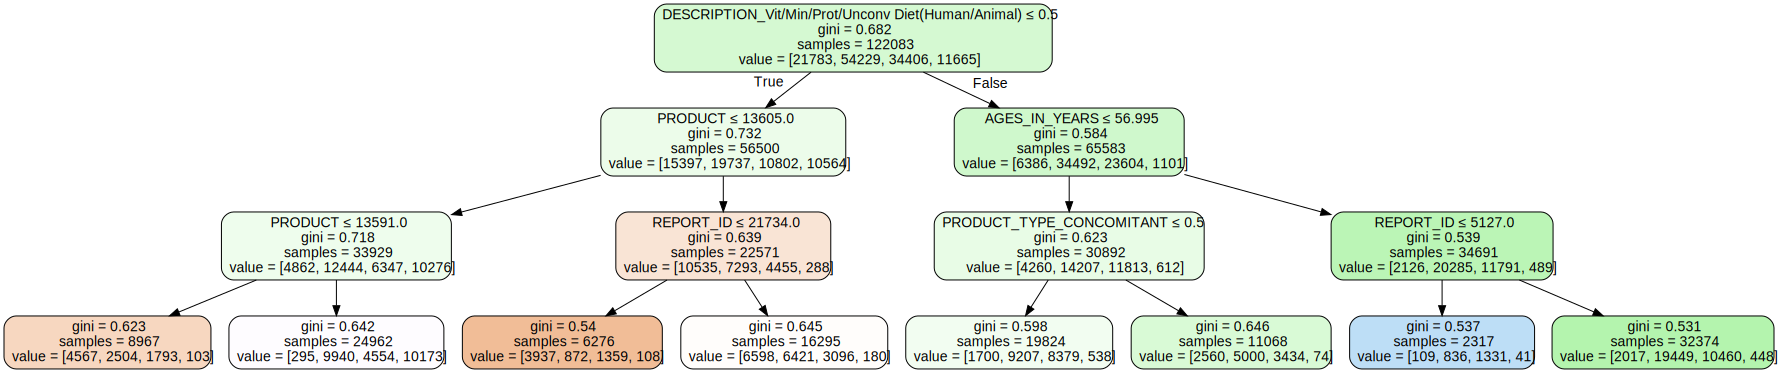

In [ ]:
# Visualize a tree
trees[0]


# Visualizing Relationships

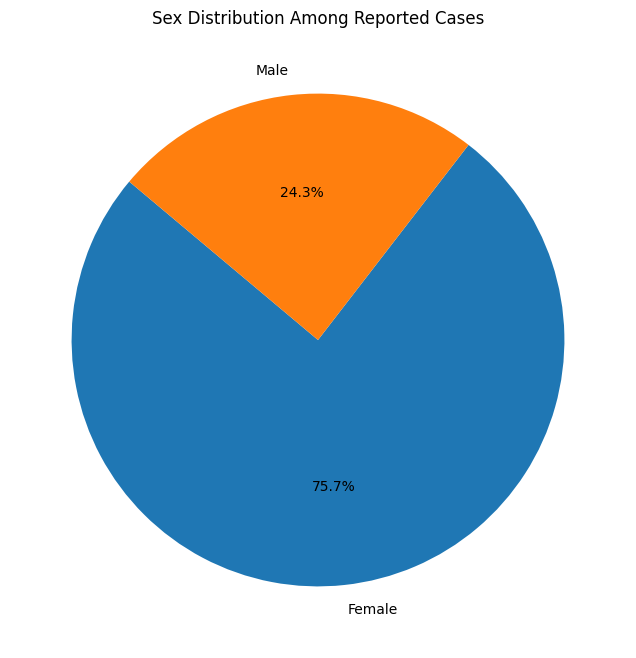

In [ ]:
#Pie Chart demonstrating the distribution of sex

# Remove duplicates based on the unique case ID
unique_cases = data_outcome_encoded.drop_duplicates(subset='REPORT_ID')

# Filter out rows where 'SEX' is NaN or has a placeholder value indicating it's not reported
reported_sex_cases = unique_cases[unique_cases['SEX'].notna() & ~unique_cases['SEX'].isin(['Not Reported', 'Unknown', ''])]

# Count the occurrences of each sex
sex_distribution = reported_sex_cases['SEX'].value_counts()

# Ensure that there are no categories with a count of 0
sex_distribution = sex_distribution[sex_distribution > 0]

# Check if there are any entries with 0 count and remove them
sex_distribution = sex_distribution[sex_distribution != 0]

# Create the pie chart only if there are valid categories to display
if not sex_distribution.empty:
    plt.figure(figsize=(8, 8))
    plt.pie(
        sex_distribution,
        labels=sex_distribution.index,
        autopct='%1.1f%%',  # Show percentage
        startangle=140  # Starting angle
    )

    plt.title('Sex Distribution Among Reported Cases')
    plt.show()
else:
    print("No reported sex data available for plotting.")


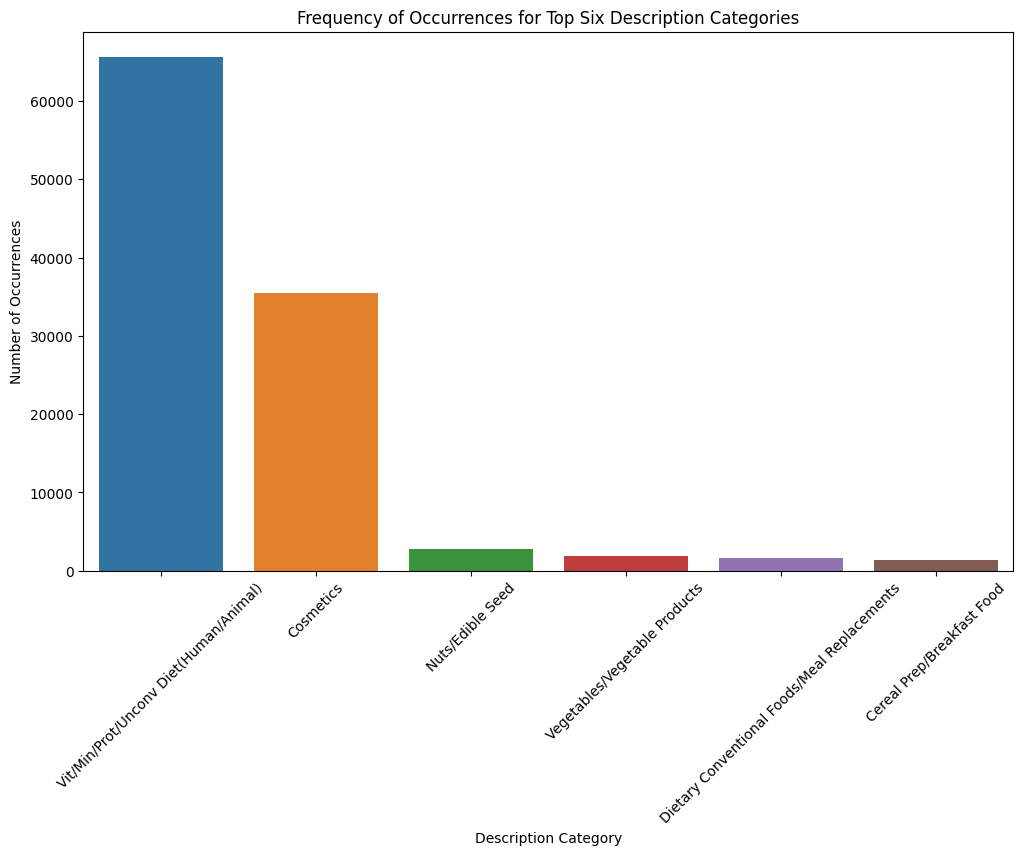

In [ ]:
# Counting the number of occurrences for each of the top six description categories
occurrences_by_description = data_outcome_encoded['DESCRIPTION'].value_counts().head(6)

# Resetting the index to create a suitable DataFrame for plotting
occurrences_df = occurrences_by_description.reset_index()
occurrences_df.columns = ['DESCRIPTION', 'COUNT']

# Creating the bar plot for the frequency of occurrences of the top six description categories
plt.figure(figsize=(12, 7))
barplot = sb.barplot(x='DESCRIPTION', y='COUNT', data=occurrences_df, hue='DESCRIPTION')

# Adding titles and labels
plt.title('Frequency of Occurrences for Top Six Description Categories')
plt.xlabel('Description Category')
plt.ylabel('Number of Occurrences')

# Rotating the x-labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


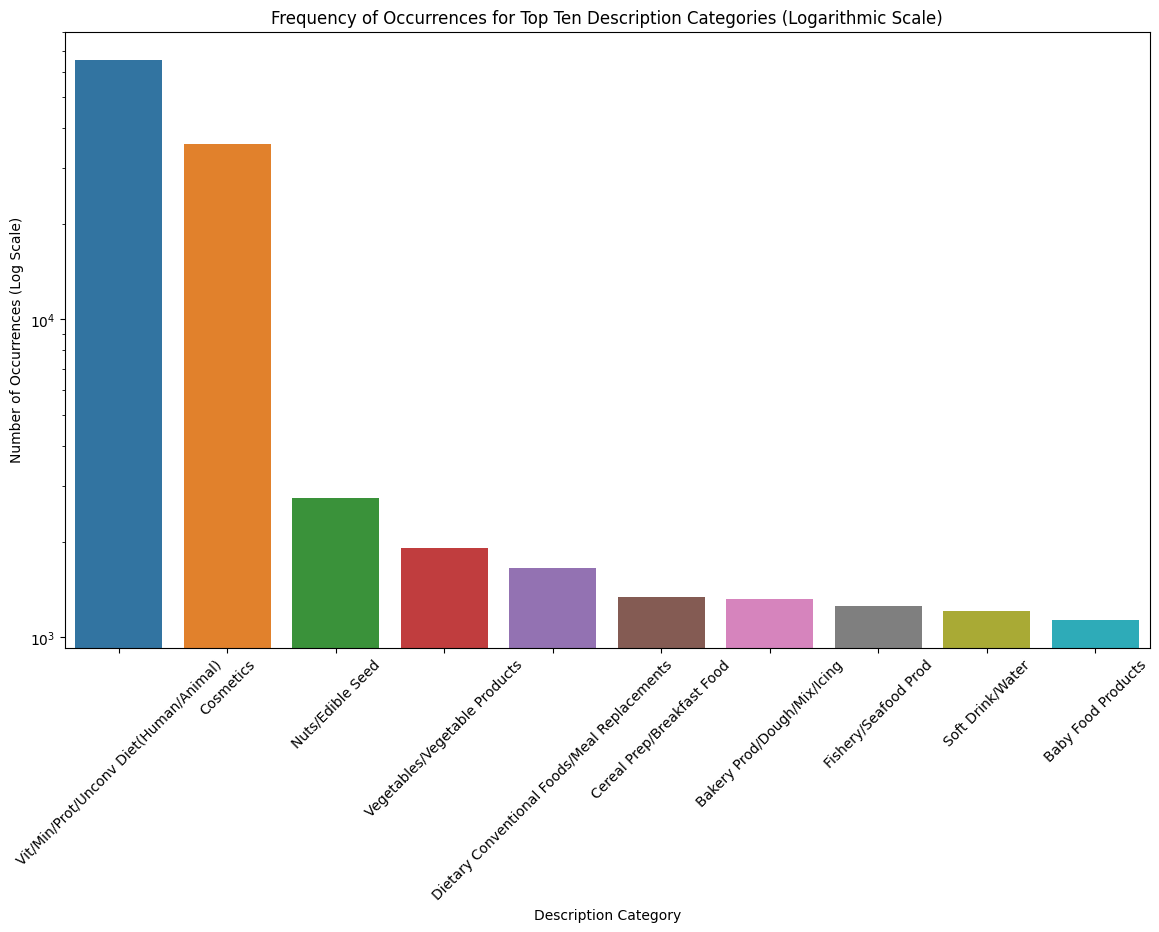

In [ ]:
import numpy as np

# Counting the number of occurrences for each of the top ten description categories
top_10_occurrences = data_outcome_encoded['DESCRIPTION'].value_counts().head(10)

# Resetting the index to create a suitable DataFrame for plotting
top_10_occurrences_df = top_10_occurrences.reset_index()
top_10_occurrences_df.columns = ['DESCRIPTION', 'COUNT']

# Creating the bar plot for the frequency of occurrences of the top ten description categories
plt.figure(figsize=(14, 8))
barplot = sb.barplot(x='DESCRIPTION', y='COUNT', data=top_10_occurrences_df, hue='DESCRIPTION')

# Adding titles and labels
plt.title('Frequency of Occurrences for Top Ten Description Categories (Logarithmic Scale)')
plt.xlabel('Description Category')
plt.ylabel('Number of Occurrences (Log Scale)')

# Setting the y-axis to a logarithmic scale
plt.yscale('log')

# Rotating the x-labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


<ipython-input-15-f9f29b40c235>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_cases['AGE_GROUP'] = pd.cut(unique_cases['AGES_IN_YEARS'], bins=age_bins, labels=age_labels, include_lowest=True)


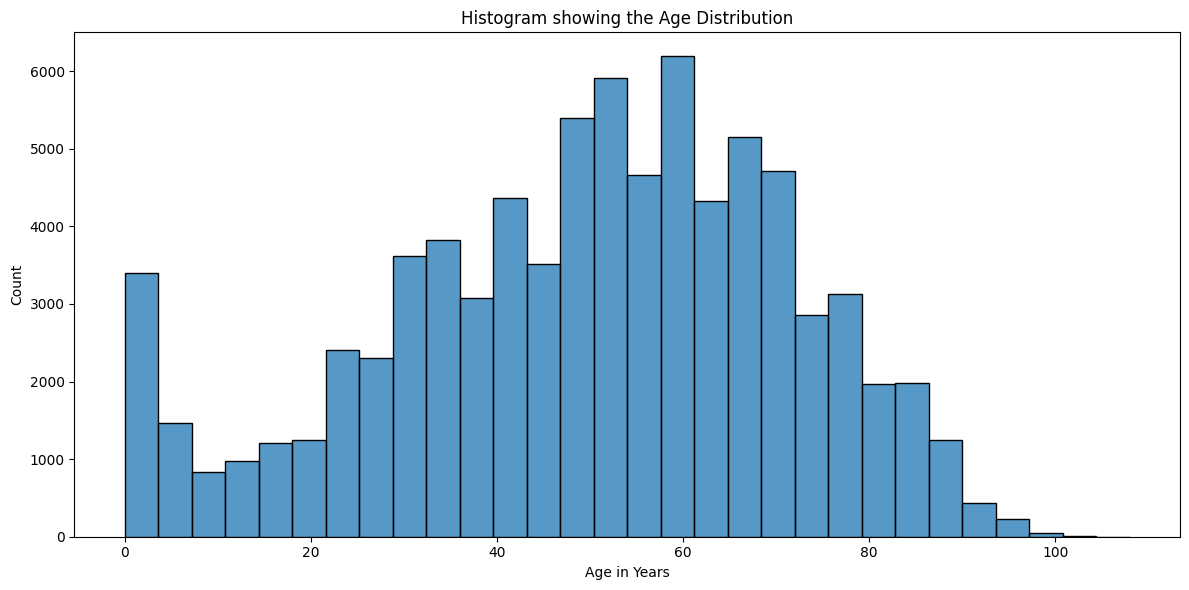

In [ ]:
# Create a new column for age groups
# Bin ages into categories
age_bins = [0, 18, 30, 40, 50, 60, 70, 80, 90, 100]  # Define the bins for ages
age_labels = ['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']  # Define the labels for the bins

unique_cases['AGE_GROUP'] = pd.cut(unique_cases['AGES_IN_YEARS'], bins=age_bins, labels=age_labels, include_lowest=True)


# Create the histogram for the 'AGES_IN_YEARS' column
plt.figure(figsize=(12, 6))
sb.histplot(data=unique_cases, x='AGES_IN_YEARS', bins=30, kde=False)

plt.title('Histogram showing the Age Distribution')
plt.xlabel('Age in Years')
plt.ylabel('Count')
plt.tight_layout()  # Adjust layout
plt.show()


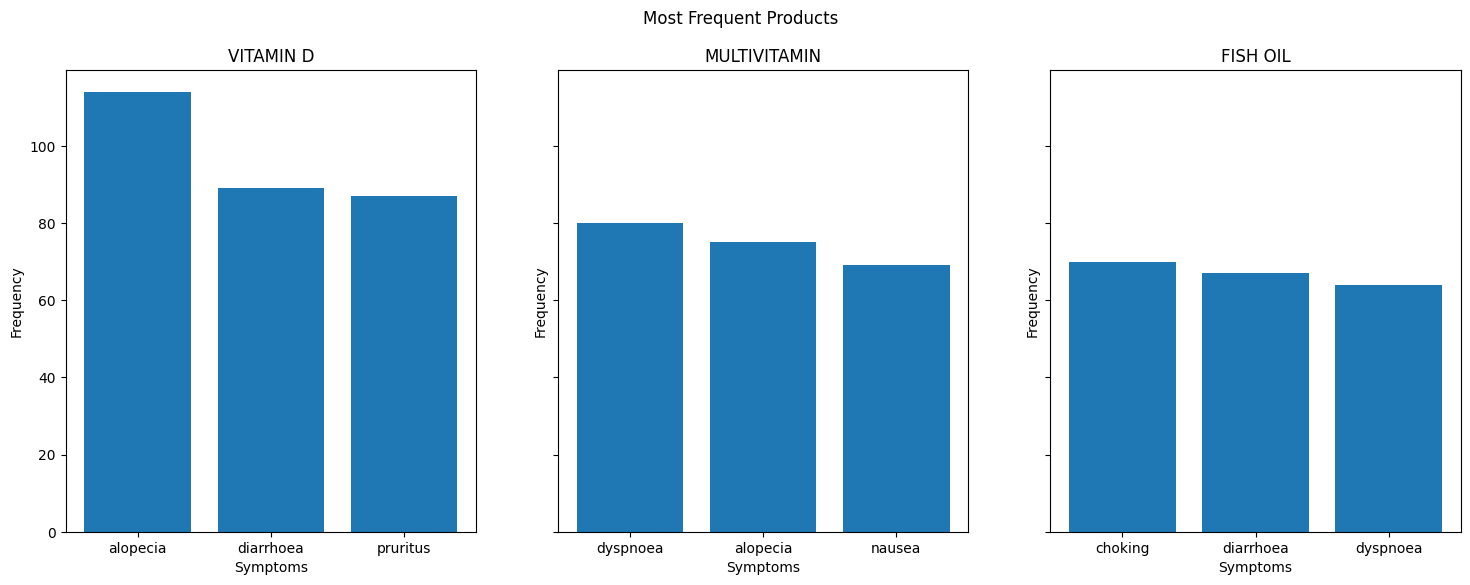

In [ ]:
# Determine which frequent products to analyze
target_products = ['VITAMIN D', 'MULTIVITAMIN', 'FISH OIL']
data_list = []
fig, axs = plt.subplots(nrows=1, ncols=len(target_products), figsize=(18, 6), sharey=True)

# Plot each graph
for idx, product in enumerate(target_products):
    product_df = df_nopc[df_nopc['PRODUCT'] == product]
    symptoms_list = [symptom for terms in product_df['CASE_MEDDRA_PREFERRED_TERMS'].str.split(', ') for symptom in terms]
    symptom_counts = Counter(symptoms_list)
    top_3_symptoms = dict(symptom_counts.most_common(3))
    data_list.append({'product': product, 'symptoms': top_3_symptoms})
    axs[idx].bar(top_3_symptoms.keys(), top_3_symptoms.values(), label=product)
    axs[idx].set_title(product)
    axs[idx].set_xlabel("Symptoms")
    axs[idx].set_ylabel("Frequency")

fig.suptitle("Most Frequent Products")

plt.show()

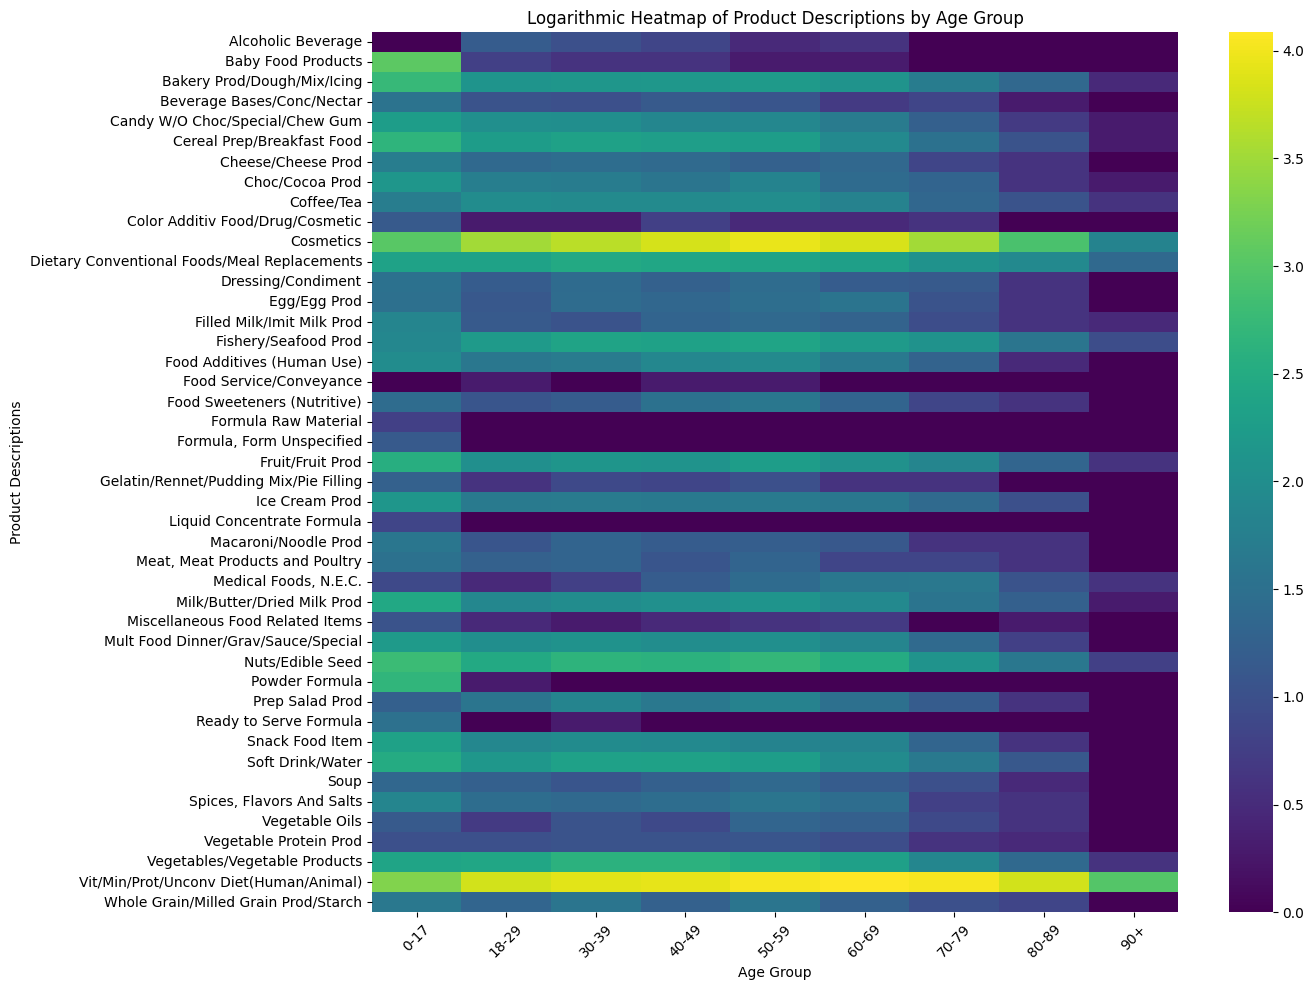

In [ ]:
# Heat Map showing the distribution of the Age Groups Against the Description of the Product

# Bin ages into categories if not already done
bins = [0, 18, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']

data_outcome_encoded['AGE_GROUP'] = pd.cut(data_outcome_encoded['AGES_IN_YEARS'], bins=bins, labels=labels, include_lowest=True)

# Prepare the data by extracting symptoms - assuming one symptom per row, if not you'll need to split and melt
# Count the occurrences of each symptom within each age group
symptom_counts = data_outcome_encoded.groupby(['AGE_GROUP', 'DESCRIPTION']).size().reset_index(name='COUNT')

# Create a pivot table for the heatmap using keyword arguments
pivot_table = symptom_counts.pivot(index='DESCRIPTION', columns='AGE_GROUP', values='COUNT')

# Apply a logarithmic transformation (+1 to avoid log(0))
pivot_table_log = np.log10(pivot_table + 1)

# Generate the heatmap with the logarithmic data
plt.figure(figsize=(14, 10))
sb.heatmap(pivot_table_log, annot=False, fmt='.2f', cmap='viridis')
plt.title('Logarithmic Heatmap of Product Descriptions by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Product Descriptions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


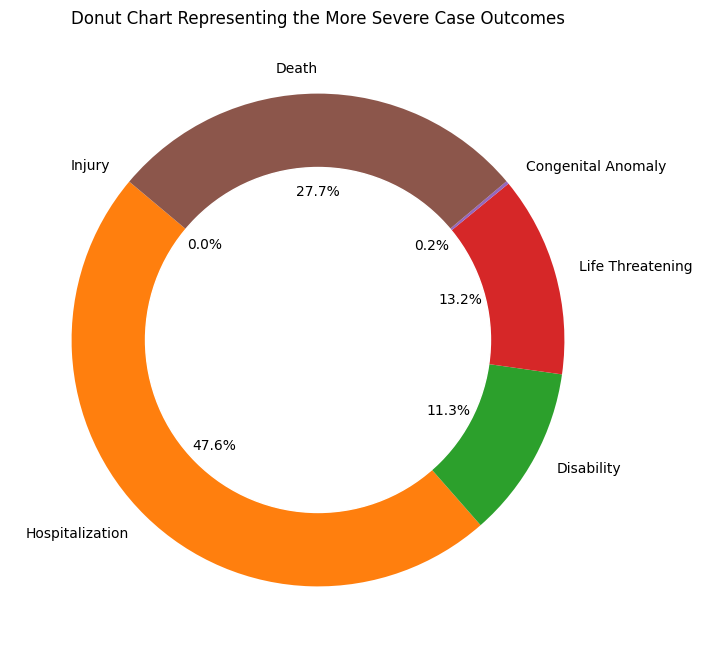

In [ ]:
#Creating a donut chart to closely look more into the five of the main case outcomes

one_hot_columns = ['Injury',
    'Hospitalization',
    'Disability',
    'Life Threatening',
    'Congenital Anomaly',
    'Death']

# Summing up the values in each of the one-hot encoded columns to get counts
category_counts = data_outcome_encoded[one_hot_columns].sum()

# Create a pie chart with a hole in the middle (donut chart)
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.gca().add_artist(plt.Circle((0, 0), 0.7, color='white'))  # Draw a white circle in the middle

plt.title('Donut Chart Representing the More Severe Case Outcomes')
plt.show()


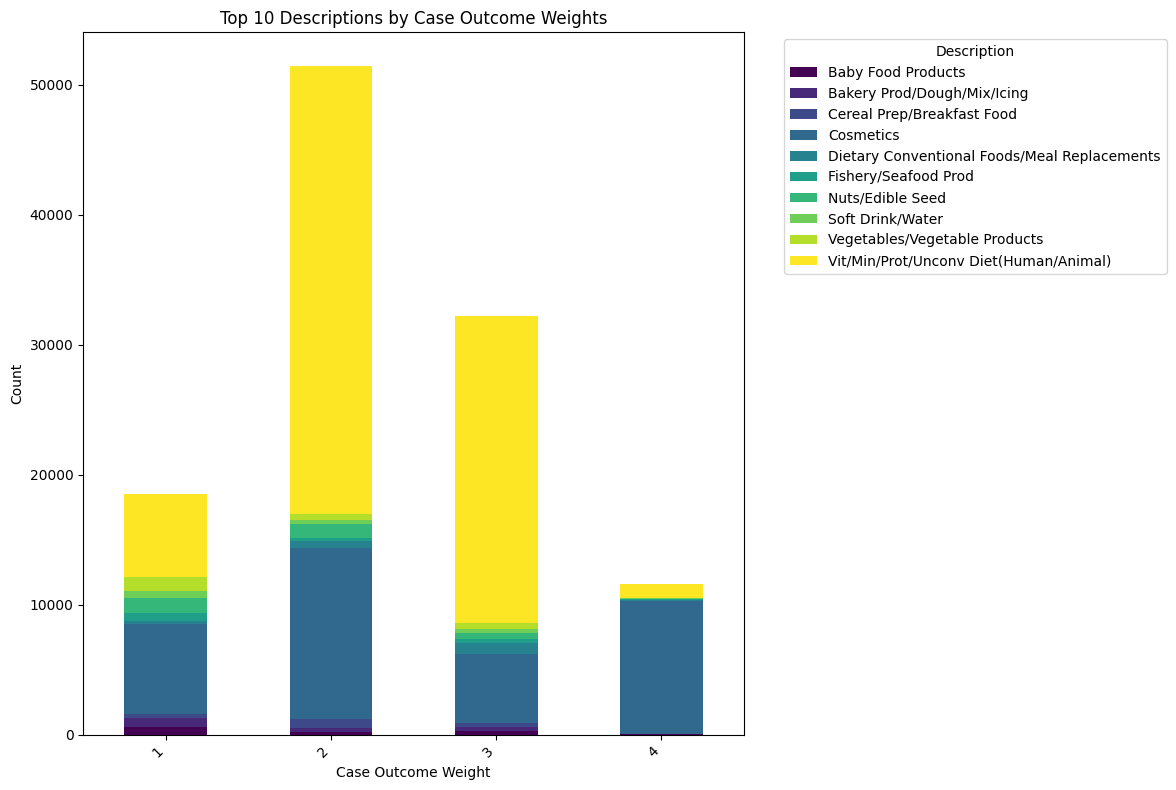

In [ ]:
# Counting occurrences of each description and selecting the top 10
top_descriptions = data_outcome_encoded['DESCRIPTION'].value_counts().head(10).index

# Filtering the dataset for only the top descriptions
top_descriptions_data = data_outcome_encoded[data_outcome_encoded['DESCRIPTION'].isin(top_descriptions)][['DESCRIPTION', 'CASE_OUTCOME_WEIGHTS']]

# Grouping the data by 'DESCRIPTION' and 'CASE_OUTCOME_WEIGHTS' and counting occurrences
grouped_data = top_descriptions_data.groupby(['DESCRIPTION', 'CASE_OUTCOME_WEIGHTS']).size().unstack(fill_value=0)

# Transposing the DataFrame to match the format needed for the stacked bar plot
stacked_data_descriptions_efficient = grouped_data.transpose()

# Plotting the stacked bar graph
stacked_data_descriptions_efficient.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.xticks(rotation=45, ha="right")
plt.xlabel('Case Outcome Weight')
plt.ylabel('Count')
plt.title('Top 10 Descriptions by Case Outcome Weights')
plt.legend(title='Description', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()
